### Stock Forecaster Test 2

In [1]:
### Libraries and Packages

In [2]:
# https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html
from lib.forecast2 import StockForecast
import matplotlib.pyplot as plt
import pandas as pd
import time
from datetime import datetime

import copy
from pathlib import Path
import warnings

from lib.scraper import StockScraper

In [3]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np

import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

### Load Raw Stock Data

In [20]:
scraper = StockScraper("AMD", interval="1d", period="20y")
scraper.from_yahoo()
scraper.data.shape, scraper.data.columns

scraper2 = StockScraper("TSLA", interval="1d", period="20y")
scraper2.from_yahoo()
scraper2.data.shape, scraper.data.columns

((3270, 7),
 Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object'))

In [27]:
amd_data = scraper.data.reset_index()
amd_data["chart"] = "AMD"
amd_data["time_idx"] = range(len(amd_data))

tsla_data = scraper2.data.reset_index()
tsla_data["chart"] = "TSLA"
tsla_data["time_idx"] = range(len(tsla_data))

stock_data = pd.concat([amd_data, tsla_data]).reset_index(drop=True)
stock_data.shape

(8304, 10)

In [28]:
stock_data.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,chart,time_idx
0,2003-06-26 00:00:00-04:00,6.35,6.58,6.33,6.55,5878900,0.0,0.0,AMD,0
1,2003-06-27 00:00:00-04:00,6.53,6.56,6.29,6.38,5368700,0.0,0.0,AMD,1
2,2003-06-30 00:00:00-04:00,6.38,6.49,6.33,6.41,4249600,0.0,0.0,AMD,2
3,2003-07-01 00:00:00-04:00,6.32,6.64,6.25,6.54,5645800,0.0,0.0,AMD,3
4,2003-07-02 00:00:00-04:00,6.55,6.77,6.55,6.75,7794100,0.0,0.0,AMD,4


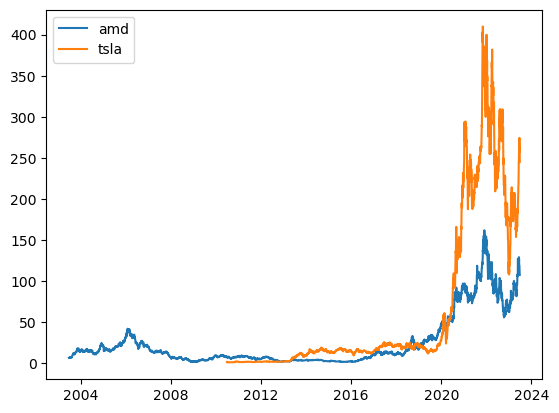

In [6]:
plt.plot(amd_data["Close"], label="amd")
plt.plot(tsla_data["Close"], label="tsla")
plt.legend()
plt.show()

### More Data

with more information the assumption is the model will get better at predictions.
1. fed meetings
2. holidays
3. stock splits
4. options volume
5. options put/call agg volume

It might also be interesting to train several stocks / indexes into one model

### Create Model Datasets

In [29]:
# https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/building.html#passing-data

max_prediction_length = 6  # forecast 6 months
max_encoder_length = 24  # use 24 months of history

# since the datetime is not periodic, we're adding a 
# fixed size incrementation for each data cell
data = stock_data

training_cutoff = data["time_idx"].max() - max_prediction_length

torch_device = "cpu"
tdevice = torch.device(torch_device)

# create trainer; normalize data, set weights, create tensors, validation - the whole 9
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    
    group_ids=["chart"],
    target="Close",
    time_idx="time_idx",
    time_varying_unknown_reals=[
        "Open", "High", "Low", "Close", "Volume"
    ],
    time_varying_known_reals=["time_idx", "Stock Splits", "Dividends"],
    static_categoricals=["chart"],
    target_normalizer=GroupNormalizer(
        groups=["chart"], transformation="softplus"
    ), 

    min_encoder_length=max_encoder_length,  # allow predictions without history
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,

    add_relative_time_idx=True,  # add as feature
    add_target_scales=True,  # add as feature
    add_encoder_length=True,  # add as feature
)

### Train the model

In [30]:
# create validation set (predict=True) which means to predict the
# last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict=True, stop_randomization=True
)
# create dataloaders for model
batch_size = 32
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

In [31]:
import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

tensor(9.4125, device='mps:0')

### Tuning the model parameters

### Use Tensorboard to monitor training

In [32]:
# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [33]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    accelerator=torch_device,
    enable_model_summary=True,
    gradient_clip_val=0.016723475628684332,
    # limit_train_batches=50,  # coment in for training, running validation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

"""
    'gradient_clip_val': 0.016723475628684332, 
    'hidden_size': 12, 
    'dropout': 0.20273552774959722, 
    'hidden_continuous_size': 9, 
    'attention_head_size': 4, 
    'learning_rate': 0.010477429830518623
"""

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.010477429830518623,
    hidden_size=12,
    attention_head_size=4,
    dropout=0.20273552774959722,
    hidden_continuous_size=9,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 17.6k


In [34]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 2     
3  | prescalers                         | ModuleDict                      | 216   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 648   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 648   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 648 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [35]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [36]:
best_model_path

'lightning_logs/lightning_logs/version_8/checkpoints/epoch=13-step=3612.ckpt'

In [37]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True, fast_dev_run=False)


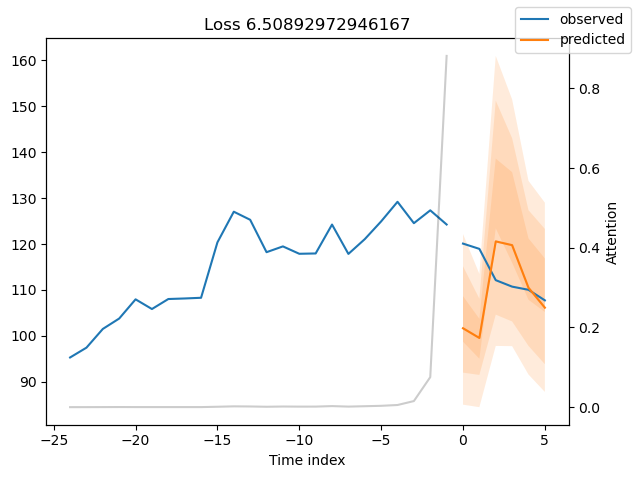

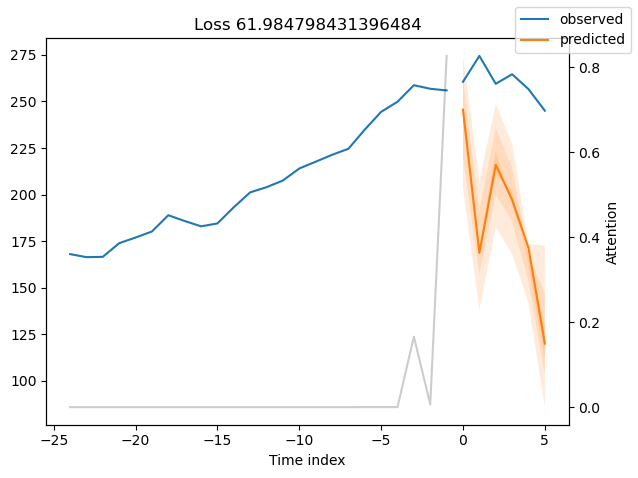

In [42]:
for idx in range(2):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

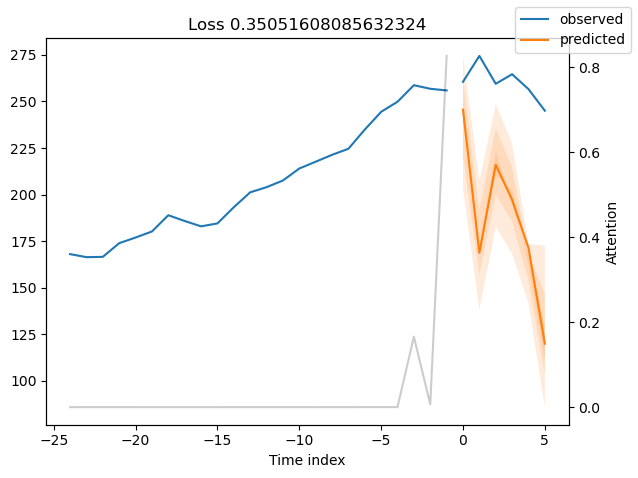

In [39]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader, return_y=True)
mean_losses = SMAPE(reduction="none")(predictions.output, predictions.y).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    )

{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'Close_center': <Figure size 1000x500 with 2 Axes>,
 'Close_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'Stock Splits': <Figure size 1000x500 with 2 Axes>,
 'Dividends': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'Open': <Figure size 1000x500 with 2 Axes>,
 'High': <Figure size 1000x500 with 2 Axes>,
 'Low': <Figure size 1000x500 with 2 Axes>,
 'Close': <Figure size 1000x500 with 2 Axes>,
 'Volume': <Figure size 1000x500 with 2 Axes>,
 'chart': <Figure size 640x480 with 2 Axes>}

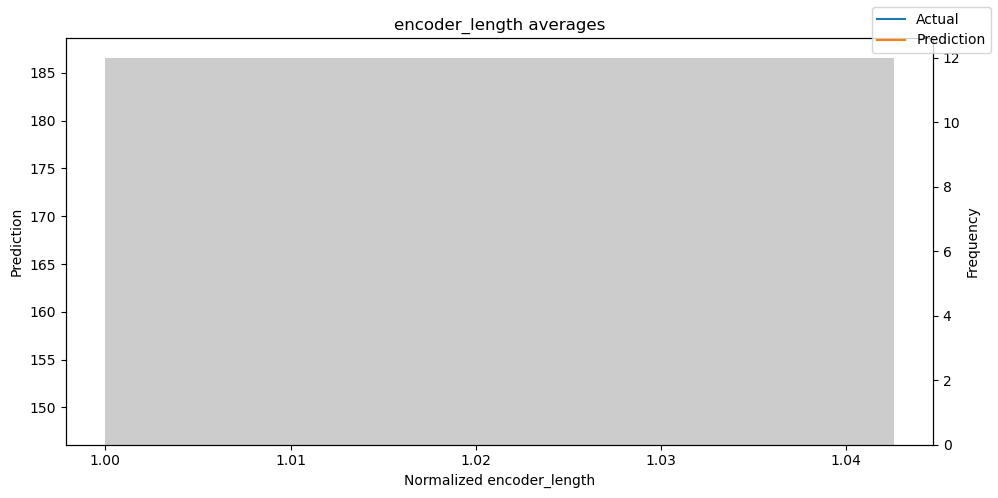

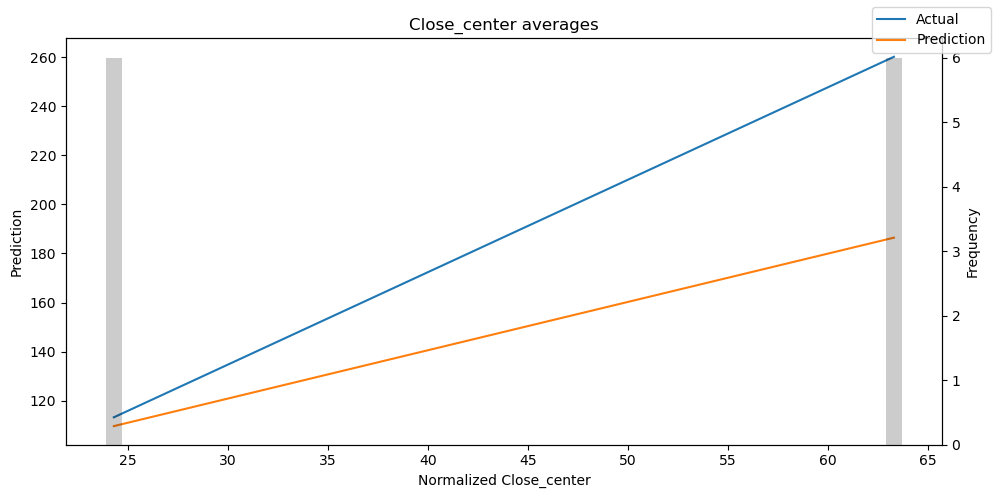

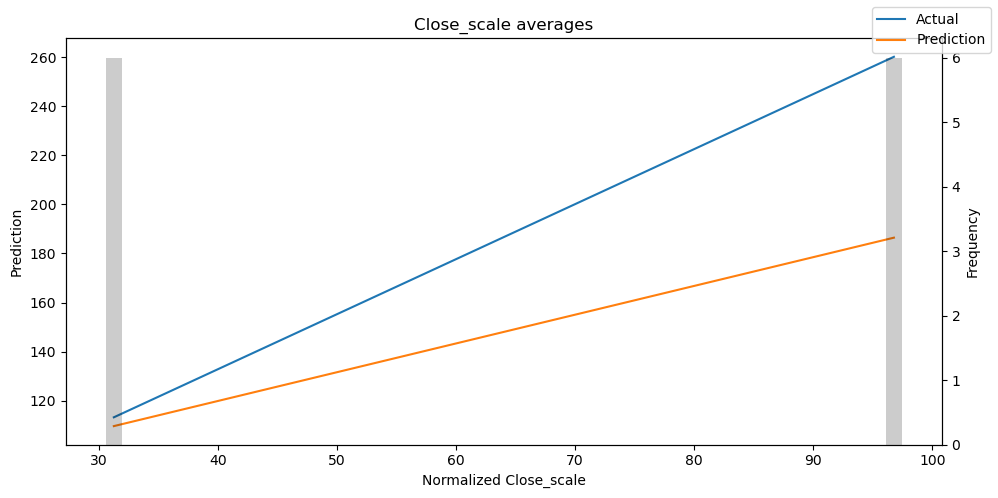

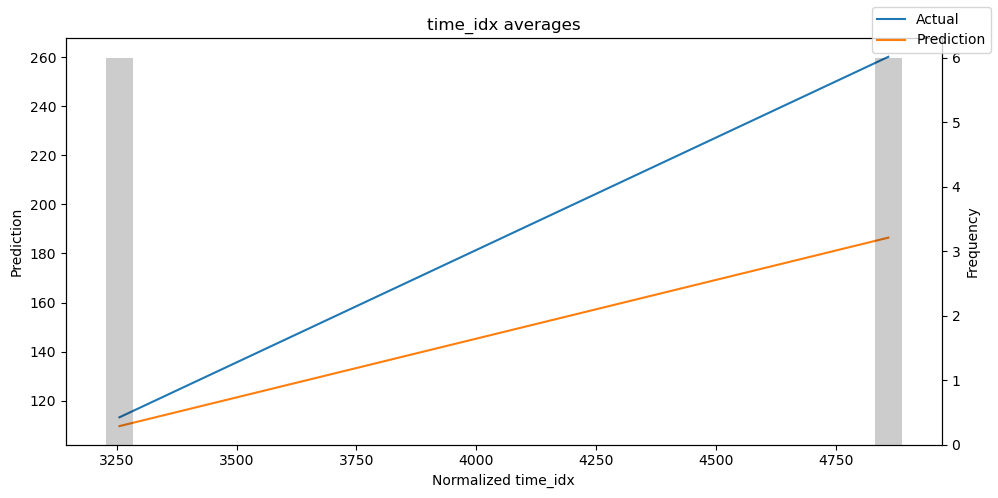

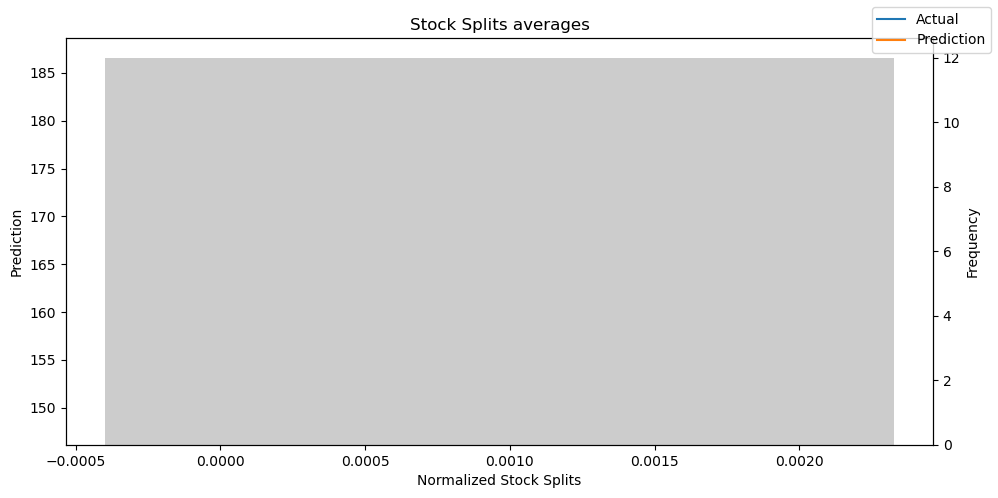

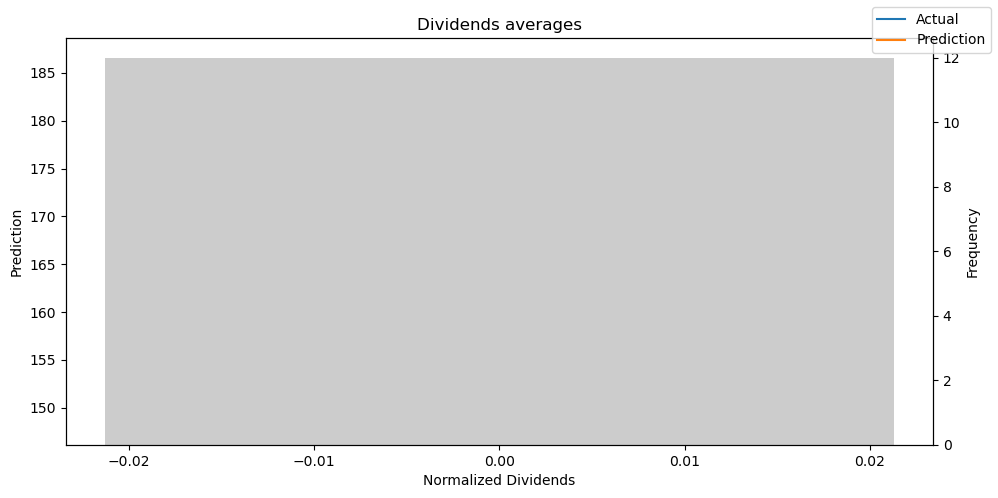

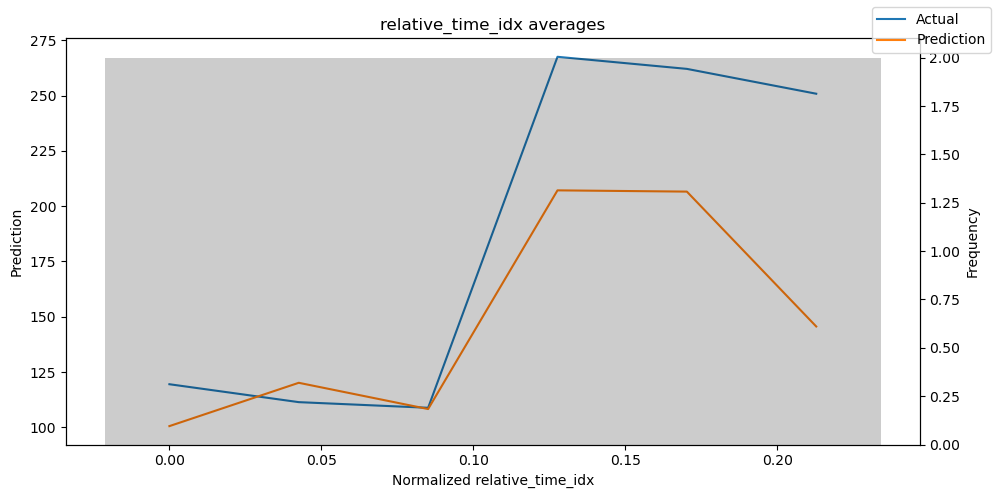

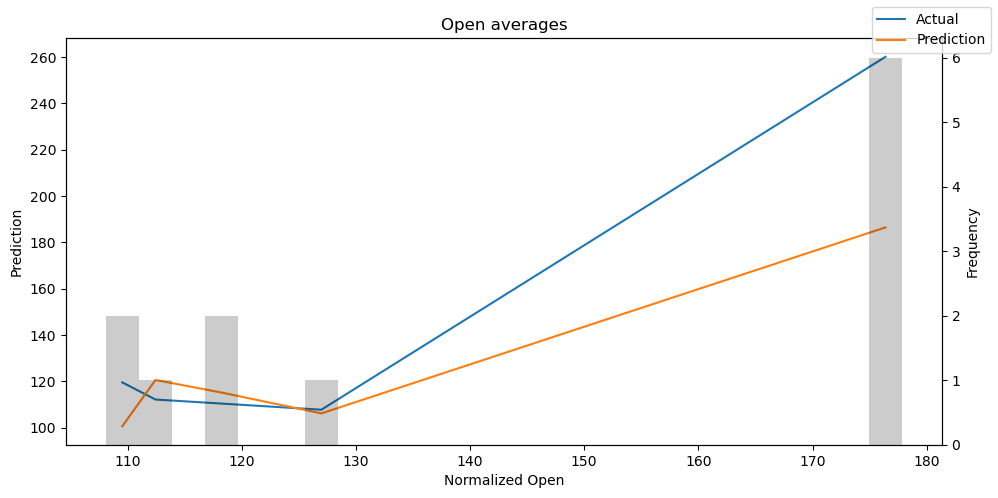

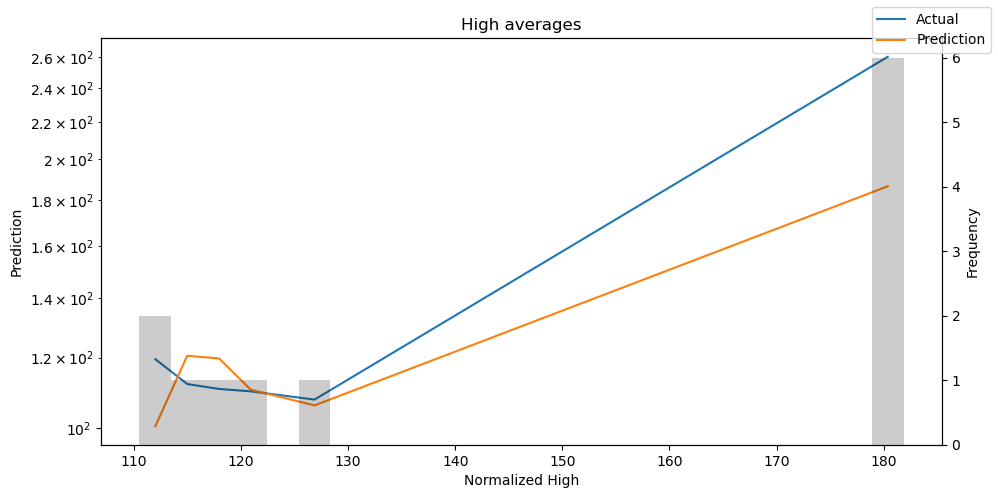

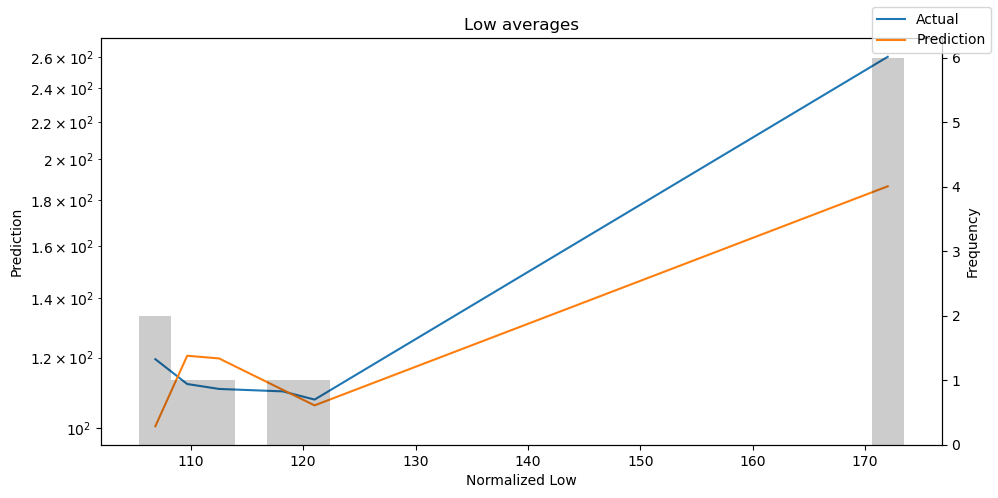

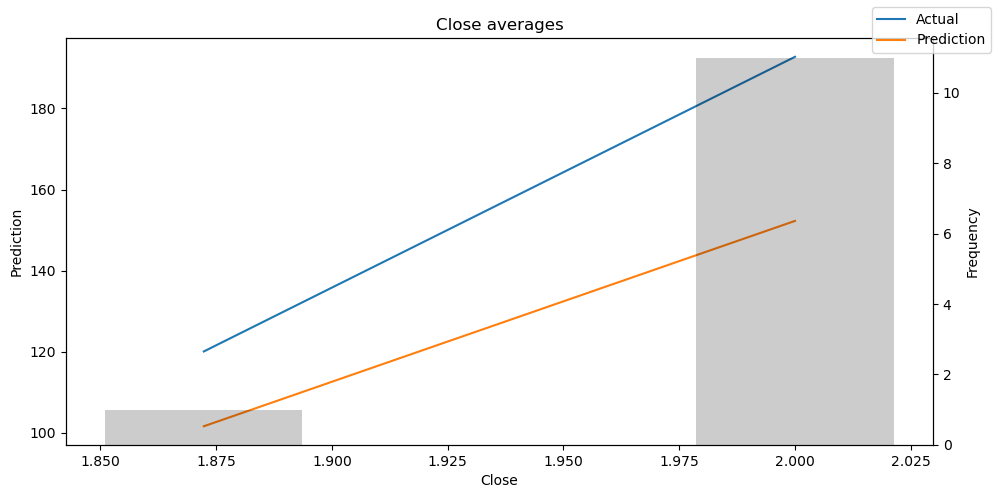

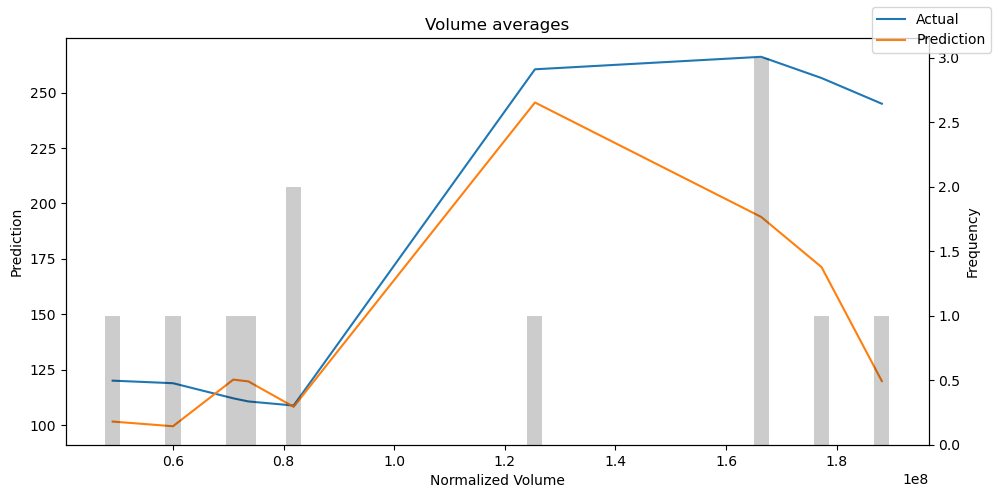

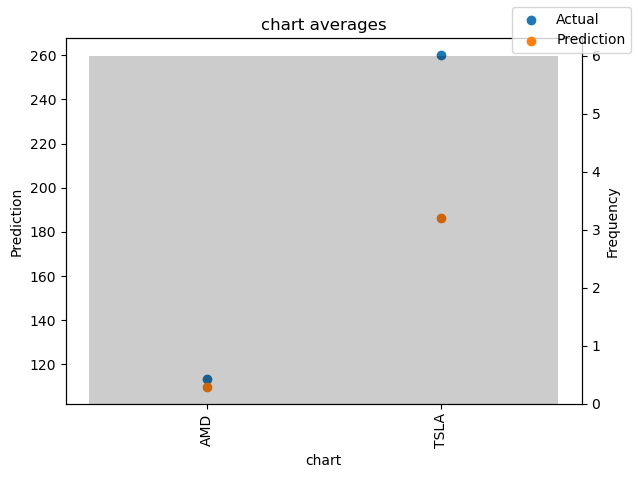

In [40]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x425 with 1 Axes>,
 'decoder_variables': <Figure size 700x300 with 1 Axes>}

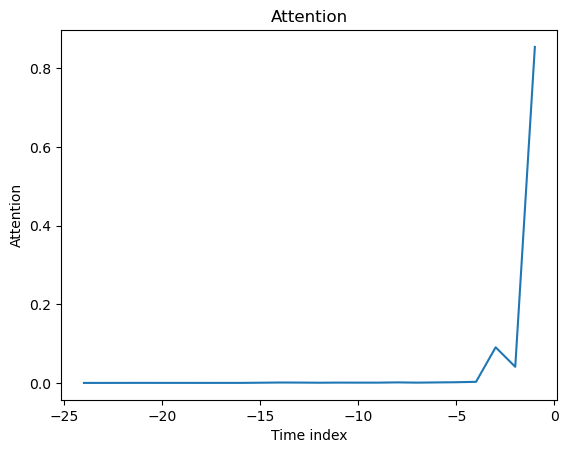

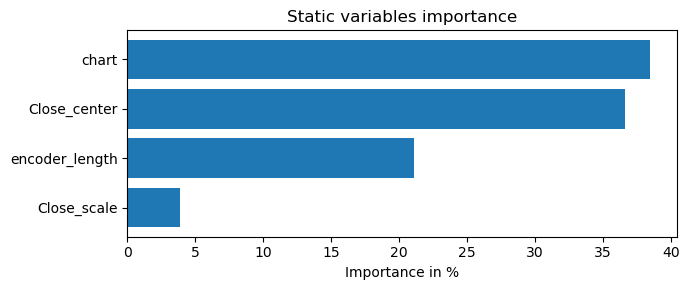

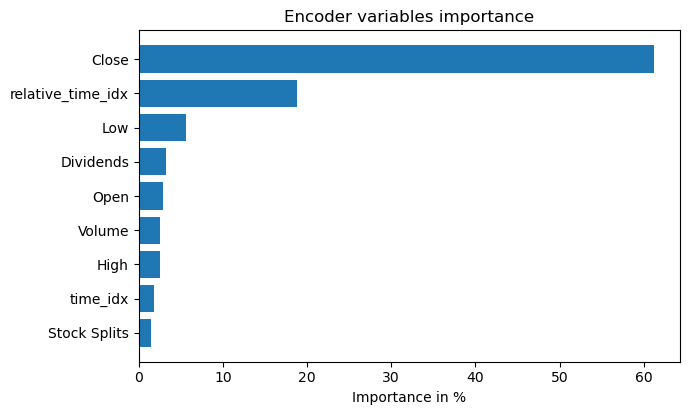

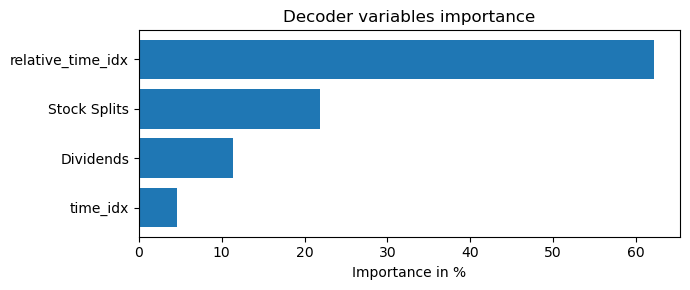

In [41]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)